In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

### Raw Plot + Raw STFT 시각화

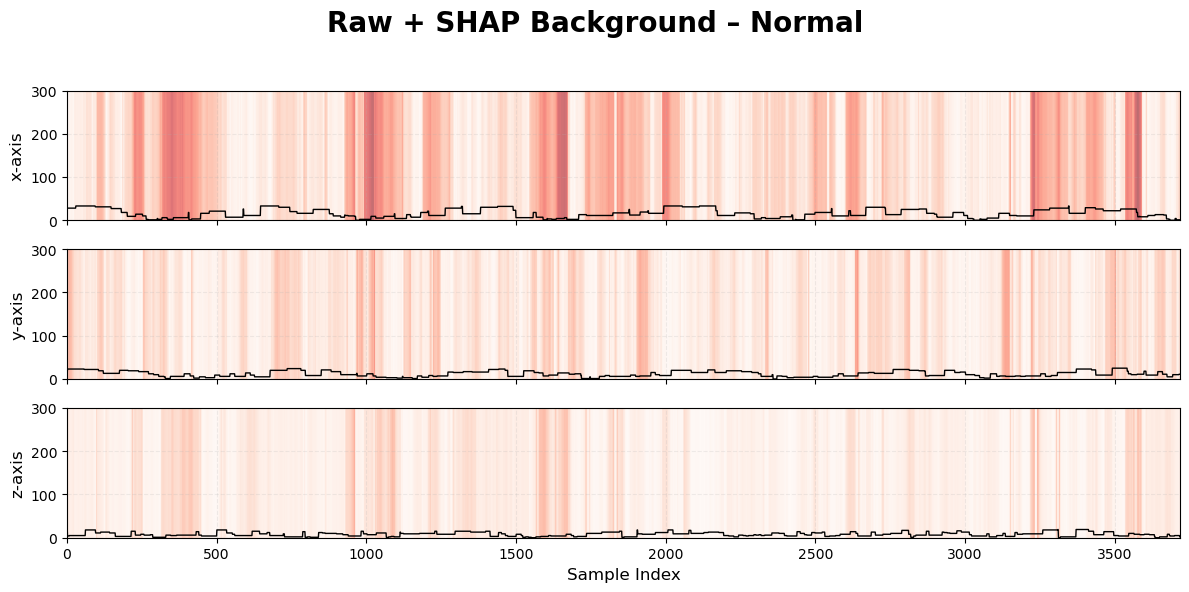

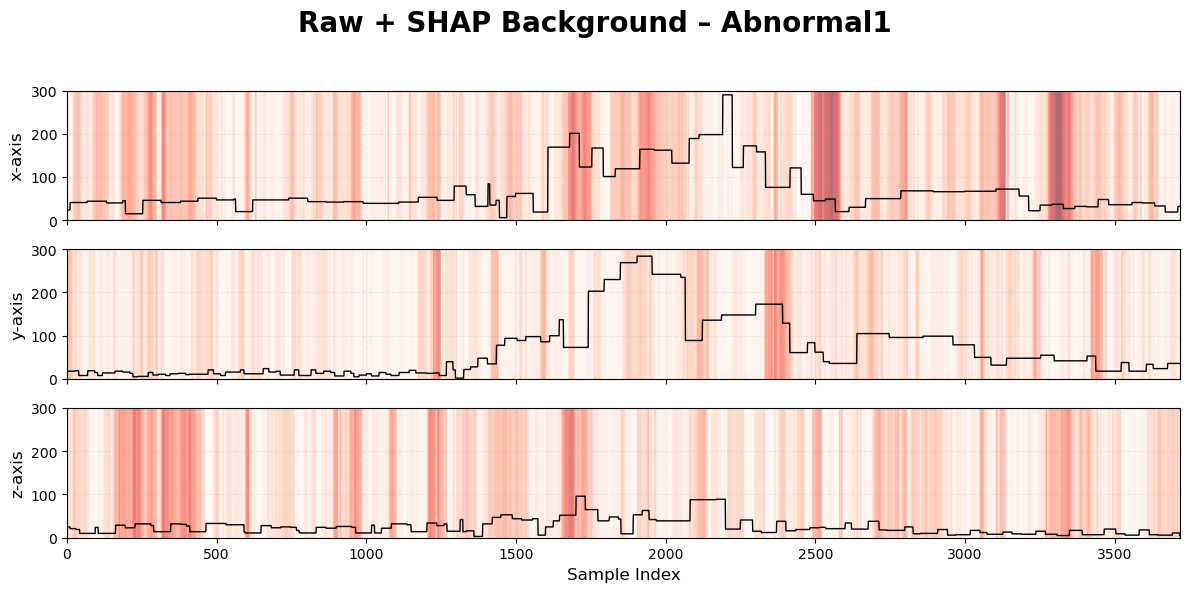

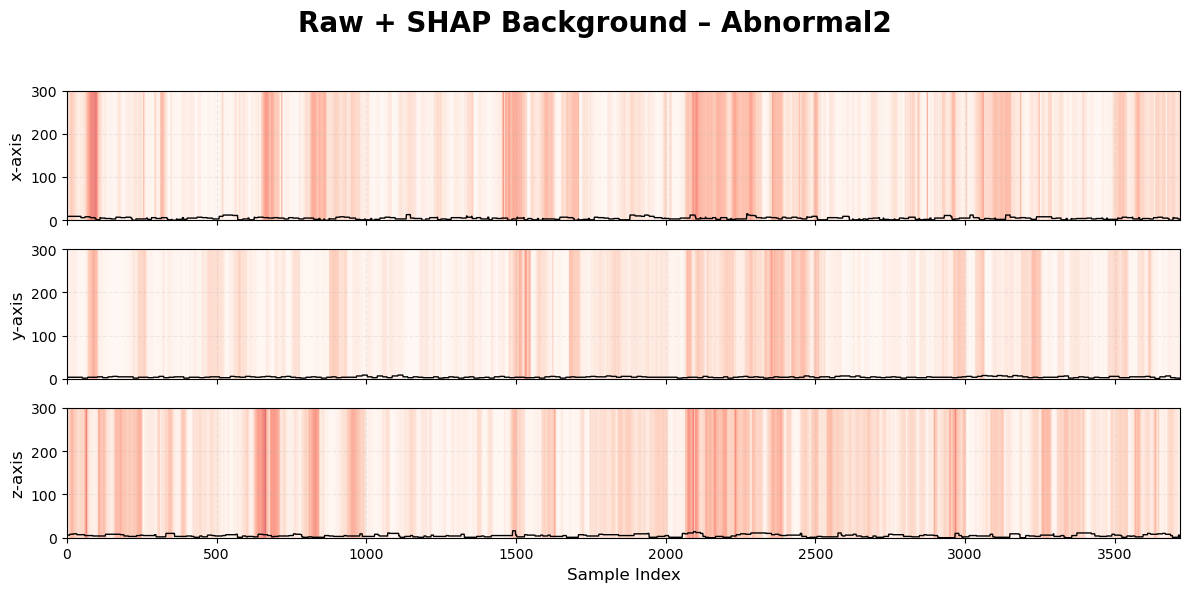

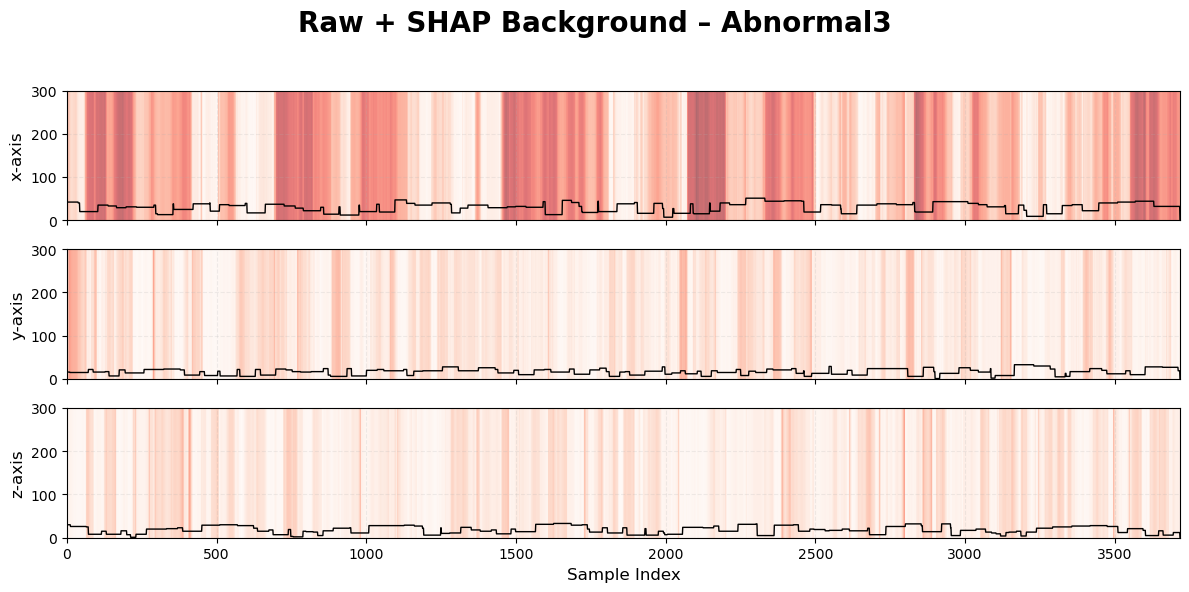

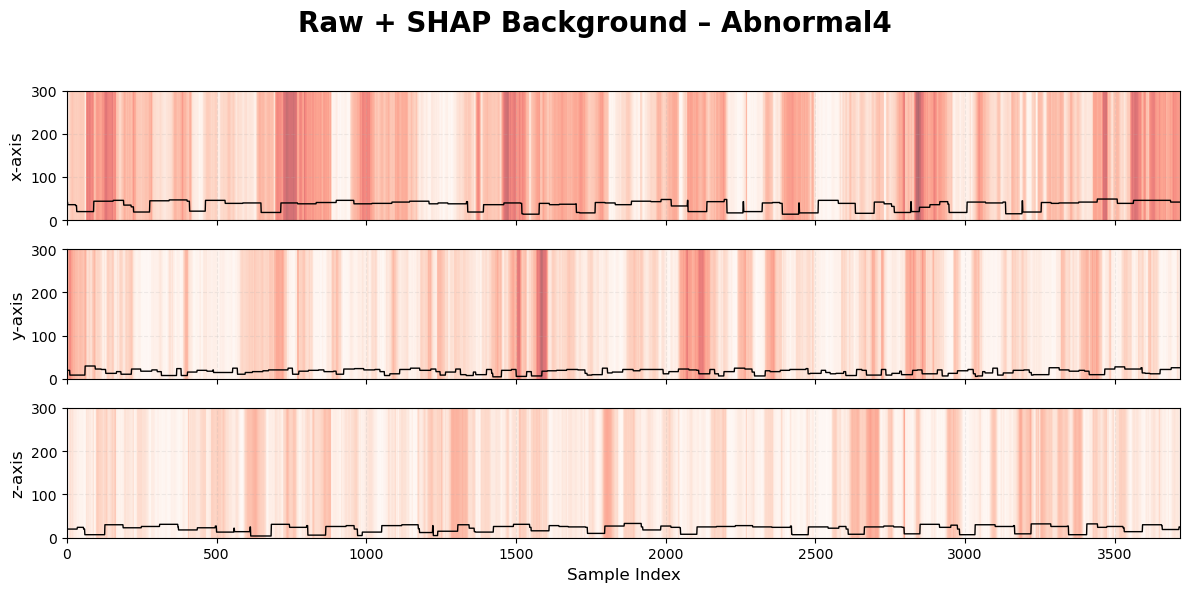

In [17]:
# Raw: 시간에 따른 변위 데이터 시각화
# SHAP: 배경 색의 강도를 표현
class_names = ["normal", "abnormal_1", "abnormal_2", "abnormal_3", "abnormal_4"]
channel_names = ["x-axis", "y-axis", "z-axis"]

RAW_FOLDER = "test_raw/test_raw_follow"  
SHAP_FOLDER = "shap_attention_results/multimodal"  
IDX_FILE = "final_results/multimodal/trial_1/predicted_indices.json"

SAVE_DIR = "figures/raw_shap_per_class"
os.makedirs(SAVE_DIR, exist_ok=True)


# ───────────────────────────────
# 2) 데이터 로드
# ───────────────────────────────
with open(IDX_FILE) as f:
    pred_idx = json.load(f)

# raw data: 클래스별 (N_windows,3,L)
raw_data = {
    cls: np.load(os.path.join(RAW_FOLDER, f"{cls}_raw_tensors.npy"))
    for cls in class_names
}

# raw SHAP: (5,3,L_shap)
raw_shap = np.load(os.path.join(SHAP_FOLDER, "raw_shap_values.npy"))

# 전역 정규화용 min/max
gmin, gmax = np.abs(raw_shap).min(), np.abs(raw_shap).max()

# ───────────────────────────────
# 3) 시각화 함수
# ───────────────────────────────
    
def plot_raw_with_shap_bg(ax, signal, shap_vals, gmin, gmax, cmap="Reds", alpha=0.6):
    L = signal.shape[0]
    y0, y1 = signal.min(), signal.max()
    # 0~1 정규화
    norm = (np.abs(shap_vals) - gmin) / (gmax - gmin + 1e-9)
    norm = np.clip(norm, 0, 1)
    # 1×L 크기로 만들어서 배경으로 깔기
    bg = norm[None, :]  # shape (1,L)
    ax.imshow(
        bg,
        cmap=cmap,
        aspect="auto",
        origin="lower",
        extent=(0, L-1, 0, 150),
        alpha=alpha,
    )
    # signal 선은 검은색, 일정 굵기
    ax.plot(signal, color="black", linewidth=1)
    ax.set_xlim(0, L-1)
    ax.set_ylim(0, 150)
    ax.grid(True, linestyle="--", alpha=0.2)
# 축 이름 정의
channel_names = ["x-axis", "y-axis", "z-axis"]


# ───────────────────────────────
# 4) 클래스별 RAW SHAP 이미지 - 화면 출력 전용
# ───────────────────────────────
for i, cls in enumerate(class_names):
    idx_list = pred_idx.get(cls, [])
    if not idx_list: 
        continue
    win_idx = idx_list[0]
    
    sig = raw_data[cls][win_idx]
    shp = raw_shap[i]
    
    Lr, Ls = sig.shape[1], shp.shape[1]
    Lm = min(Lr, Ls)
    sig = sig[:, :Lm]
    shp = shp[:, :Lm]
    y_max = 300
    title_cls_name = cls.replace("_", " ").title().replace(" ", "")

    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    fig.suptitle(f"Raw + SHAP Background – {title_cls_name}", fontsize=20, fontweight='bold')
    for ch in range(3):
        L = sig.shape[1]
        norm = (np.abs(shp[ch]) - gmin) / (gmax - gmin + 1e-9)
        norm = np.clip(norm, 0, 1)
        bg = norm[None, :]
        axes[ch].imshow(
            bg,
            cmap="Reds",
            aspect="auto",
            origin="lower",
            extent=(0, L-1, 0, y_max),
            alpha=0.6,
        )
        axes[ch].plot(sig[ch], color="black", linewidth=1)
        axes[ch].set_xlim(0, L-1)
        axes[ch].set_ylim(0, y_max)
        axes[ch].grid(True, linestyle="--", alpha=0.2)
        axes[ch].set_ylabel(channel_names[ch], fontsize=12)

    axes[-1].set_xlabel("Sample Index", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [18]:
# ───────────────────────────────
# 4) 클래스별 RAW SHAP 이미지 저장
# ───────────────────────────────
for i, cls in enumerate(class_names):
    idx_list = pred_idx.get(cls, [])
    if not idx_list: 
        continue
    win_idx = idx_list[0]

    sig = raw_data[cls][win_idx]
    shp = raw_shap[i]

    Lr, Ls = sig.shape[1], shp.shape[1]
    Lm = min(Lr, Ls)
    sig = sig[:, :Lm]
    shp = shp[:, :Lm]
    y_max = 300
    title_cls_name = cls.replace("_", " ").title().replace(" ", "")

    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    fig.suptitle(f"Raw + SHAP Background – {title_cls_name}", fontsize=20, fontweight='bold')
    for ch in range(3):
        L = sig.shape[1]
        norm = (np.abs(shp[ch]) - gmin) / (gmax - gmin + 1e-9)
        norm = np.clip(norm, 0, 1)
        bg = norm[None, :]
        axes[ch].imshow(
            bg,
            cmap="Reds",
            aspect="auto",
            origin="lower",
            extent=(0, L-1, 0, y_max),
            alpha=0.6,
        )
        axes[ch].plot(sig[ch], color="black", linewidth=1)
        axes[ch].set_xlim(0, L-1)
        axes[ch].set_ylim(0, y_max)
        axes[ch].grid(True, linestyle="--", alpha=0.2)
        axes[ch].set_ylabel(channel_names[ch], fontsize=12)

    axes[-1].set_xlabel("Sample Index", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(SAVE_DIR, f"{title_cls_name}_raw_shap.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

print(f"✅ 저장 완료: {SAVE_DIR} 폴더 내에 클래스별 이미지 저장됨")

✅ 저장 완료: figures/raw_shap_per_class 폴더 내에 클래스별 이미지 저장됨


In [19]:


# 1. 불러오기
save_dir = "shap_attention_results/multimodal"
stft_shap = np.load(f"{save_dir}/stft_shap_values.npy")    # shape: (5, 3, F, T)
attn_maps = np.load(f"{save_dir}/attention_maps.npy")      # shape: (5, H, Tq, Tk)

class_names = ["normal", "abnormal_1", "abnormal_2", "abnormal_3", "abnormal_4"]

# STFT SHAP 전체 범위 계산
stft_vmin = np.min(stft_shap)
stft_vmax = np.max(stft_shap)

# Attention 전체 범위 계산
attn_vmin = np.min(attn_maps)
attn_vmax = np.max(attn_maps)

# 2. STFT SHAP 시각화 함수 정의- 클래스별, 채널별 시각화
def plot_stft_shap_all():
    fig, axes = plt.subplots(len(class_names), 3, figsize=(15, 12))
    for i, cls in enumerate(class_names):
        for ch in range(3):
            im = axes[i, ch].imshow(
                stft_shap[i, ch],
                aspect='auto',
                cmap='RdBu_r',
                origin='lower',
                vmin=stft_vmin,
                vmax=stft_vmax
            )
            axes[i, ch].set_title(f"{cls} - Ch{ch}")
            fig.colorbar(im, ax=axes[i, ch])
    plt.suptitle("STFT SHAP (Channel-wise)", fontsize=16)
    plt.tight_layout()
    plt.show()

# 3. Attention Map 시각화 함수 저으이 - 클래스별, Head별 시각화
def plot_attention_all():
    n_class = len(class_names)
    n_heads = attn_maps.shape[1]
    fig, axes = plt.subplots(n_class, n_heads, figsize=(4 * n_heads, 2.5 * n_class))

    for i, cls in enumerate(class_names):
        for h in range(n_heads):
            ax = axes[i, h] if n_heads > 1 else axes[i]
            im = ax.imshow(
                attn_maps[i, h],
                cmap='viridis',
                origin='lower',
                vmin=attn_vmin,
                vmax=attn_vmax
            )
            ax.set_title(f"{cls} - Head {h}")
            fig.colorbar(im, ax=ax)
    plt.suptitle("Cross Attention Map (Head-wise)", fontsize=16)
    plt.tight_layout()
    plt.show()

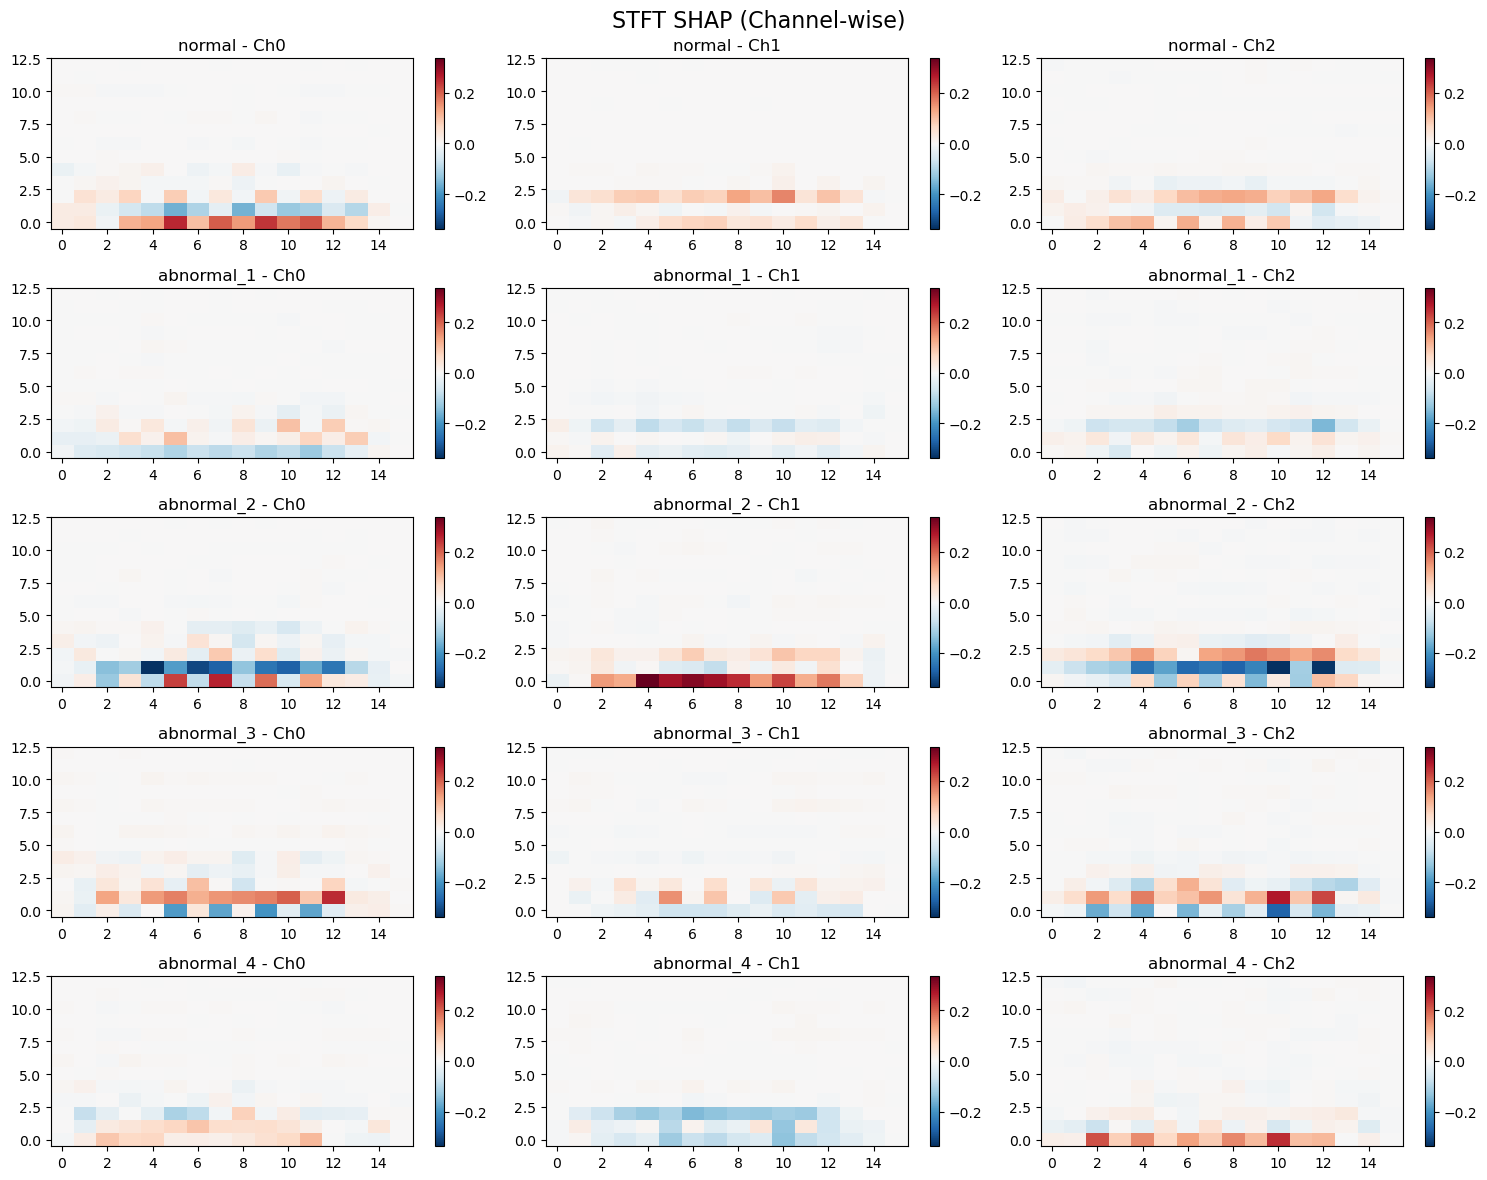

In [20]:
# STFT SHAP 시각화
plot_stft_shap_all()

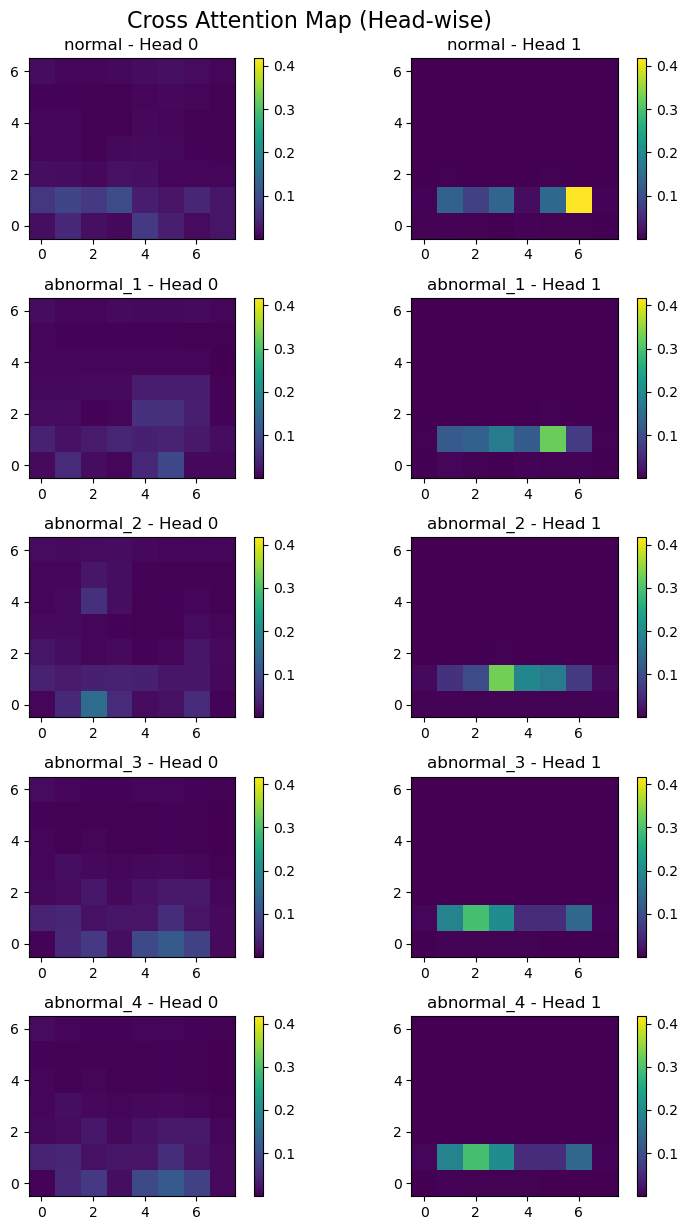

In [21]:
# Attention map 시각화
plot_attention_all()

In [22]:
class_names = ["Normal", "Abnormal1", "Abnormal2", "Abnormal3", "Abnormal4"]

# STFT SHAP 클래스 별 이미지 저장
def save_stft_shap_per_class(save_dir="figures/stft_shap"):
    os.makedirs(save_dir, exist_ok=True)
    channel_names = ['x-axis', 'y-axis', 'z-axis']

    for i, cls in enumerate(class_names):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for ch in range(3):
            im = axes[ch].imshow(
                stft_shap[i, ch],
                aspect='auto',
                cmap='RdBu_r',
                origin='lower',
                vmin=stft_vmin,
                vmax=stft_vmax
            )
            axes[ch].set_title(f"{cls} - {channel_names[ch]}", fontsize = 16, fontweight='bold')
            axes[ch].tick_params(axis='both', labelsize=13)  # 축 눈금 폰트 크기
            cbar = fig.colorbar(im, ax=axes[ch])
            cbar.ax.tick_params(labelsize=14)  # 색상바 눈금 크기
        plt.suptitle(f"STFT SHAP - {cls}", fontsize=20, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{cls}_stft_shap.png"), dpi=300)
        plt.close()

save_stft_shap_per_class()

In [23]:
# Attention map 클래스 별 이미지 저장
def save_attention_per_class(save_dir="figures/attention_map"):
    os.makedirs(save_dir, exist_ok=True)
    n_heads = attn_maps.shape[1]

    # ✅ 전체 attention 값 기준으로 정규화 범위 계산
    attn_vmin = attn_maps.min()
    attn_vmax = attn_maps.max()

    for i, cls in enumerate(class_names):
        fig, axes = plt.subplots(1, n_heads, figsize=(4 * n_heads, 4))
        for h in range(n_heads):
            ax = axes[h] if n_heads > 1 else axes
            im = ax.imshow(
                attn_maps[i, h],
                cmap='viridis',
                origin='lower',
                vmin=attn_vmin,
                vmax=attn_vmax
            )
            ax.set_title(f"Head {h}")
            fig.colorbar(im, ax=ax)
        plt.suptitle(f"Cross Attention - {cls}", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{cls}_attention_map.png"))
        plt.close()


save_attention_per_class()